[View in Colaboratory](https://colab.research.google.com/github/omendezmorales/astropy-tutorials/blob/master/Extinction_and_Color_Excess.ipynb)

# Dereddening a spectrum and calculating reddening

##Contributors
Kristen Larson (@krislars), Emir Karamehmetoglu (@emirkmo)

## Learning Goals
- Investigate extinction curve shapes
- Redden and deredden spectra
- Calculate photometric extinction and reddening
- Use `dust_extinction` and `synphot` together





## Keywords
`dust_extinction`,  `synphot`

*Some text will go here.*

## Install

In [16]:
# For running in Google Colaboratory:
!pip install astropy
!pip install dust_extinction
!pip install synphot

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.table import Table
from dust_extinction.dust_extinction import CCM89, F99

In [0]:
from synphot import units,SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve

# Example 1: Investigate Extinction Models

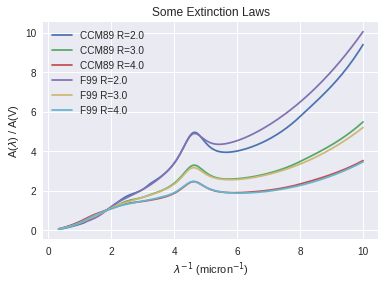

In [19]:
wav = np.arange(0.1, 3, 0.001)*u.micron # Create wavelengths

for model in [CCM89,F99]:
  for R in (2.0,3.0,4.0):
    ext = model(Rv=R) # Initialize the extinction model
    plt.plot(1/wav, ext(wav), label=model.name+' R='+str(R))
plt.xlabel('$\lambda^{-1}$ (micron$^{-1}$)')
plt.ylabel('A($\lambda$) / A(V)')
plt.legend(loc='best')
plt.title('Some Extinction Laws')
plt.show()

# Example 2: Deredden Spectrum

Here we deredden (unextinguish) the IUE ultraviolet spectrum of the star $\rho$ Oph. 

First, we fetch spectrum from the archive and read the data into an astropy table.

In [0]:
x1,y1 = np.loadtxt('http://archive.stsci.edu/missions/iue/previews/mx/lwr/05000/gz/lr05639.gz',
               unpack=True,skiprows=20,usecols=(0,1))

x2,y2 = np.loadtxt('http://archive.stsci.edu/missions/iue/previews/mx/swp/06000/gz/sp06588.gz',
               unpack=True,skiprows=20,usecols=(0,1))

rhoOph = Table()
rhoOph['wav'] = np.append(x2,x1)*u.AA
rhoOph['flux'] = np.append(y2,y1)*u.erg/(u.cm*u.cm*u.s*u.AA)

Then, we initialize the extinction model, choosing a value for Rv and reddening.

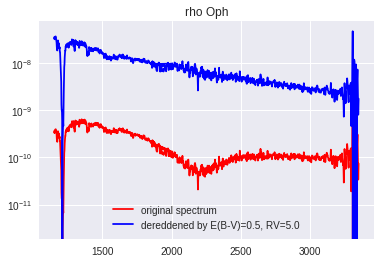

In [21]:
Rv = 5.0
Ebv = 0.5

ext = F99(Rv=Rv)
rhoOph['extcorr'] = rhoOph['flux']/ext.extinguish(rhoOph['wav'], Ebv=Ebv)

plt.semilogy(rhoOph['wav'],rhoOph['flux'],'r',label='original spectrum')
plt.semilogy(rhoOph['wav'],rhoOph['extcorr'],'b',
         label='dereddened by E(B-V)='+str(Ebv)+', RV='+str(Rv))
plt.legend(loc='best')
plt.title('rho Oph')
plt.show()

# Example 3: Calculate color excess with `synphot`

In [0]:
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

The lines above get the filter transmission curves from an FTP server at STScI.  If they don't work, you can try this instead:

`from synphot import config` \\
`config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits` \\
`config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits`

and so on for the rest of the filters you want.  If you are running this with your own python, see the [`synphot` documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup) on how to download your own copy of the necessary files.

First, we make some data.  Here, we make a blackbody using the model mechanism from within `synphot` and normalize it to V = 10 in the Vega-based system.

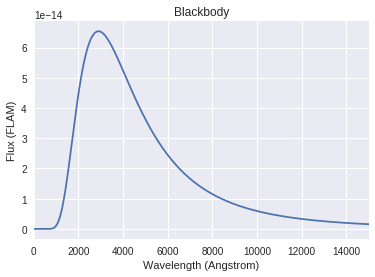

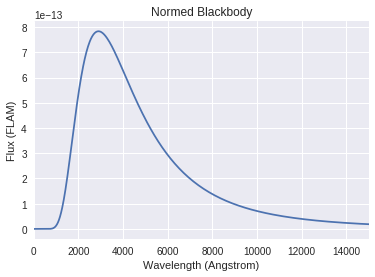

In [23]:
# First create a blackbody
sp = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Then get the Vega spectrum as the zero point flux
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody')

Next, we initialize the extinction model.  To get the `dust_extinction` model working with `synphot`, we create a wavelength array and make a spectral element with the extinction model as a lookup table.

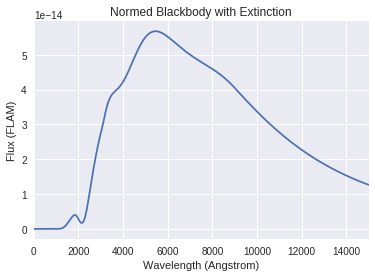

In [24]:
# Initialize the extinction model and choose the extinction, Av = 2
ext = CCM89(Rv=3.1)
Av = 2.

# Create a wavelength array 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table 
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction')

Synthetic photometry means sending the astronomical flux through a certain filter...

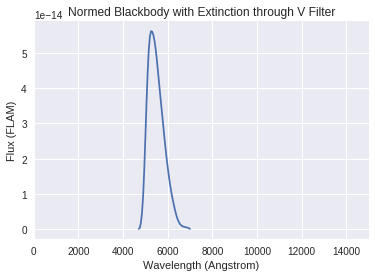

In [25]:
# "Observe" the star through the filter, and integrate to get photometric mag
sp_obs = Observation(sp_ext, v_band)
sp_obs_before = Observation(sp_norm, v_band)
sp_obs.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction through V Filter')

...and integrating it to get a flux.  The "effective stimulus" in `synphot` refers to the integrated flux that would be incident on a detector.  Invoking the Vega flux unit will convert the flux to a Vega-based magnitude system. 

In [26]:
sp_stim_before = sp_obs_before.effstim(flux_unit='vegamag', vegaspec=vega)
sp_stim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
print('before dust, V=', sp_stim_before)
print('after dust, V=', sp_stim)

# Calculate extinction and compare to setting above
Av = sp_stim - sp_stim_before
print('$A_V$ = ', Av)

before dust, V= 9.9901706994327 VEGAMAG
after dust, V= 11.979649269144566 VEGAMAG
$A_V$ =  1.989478569711867 VEGAMAG


Ah, good!  We normalized our spectrum to V = 10 mag and added 2 mag of visual extinction, and our synthetic photometry reproduces these chosen values.  We're feeling ready to find the extinction in other passbands. 

We calculate the new photometry for the rest of the Johnson optical and the Bessell infrared filters. We calculate extinction $A = \Delta m$ and plot reddening (color excess), $E(\lambda - V) = A_\lambda - A_V$.  

Notice that `synphot` calculated the effective wavelength of the observations for us.  Handy for plotting!

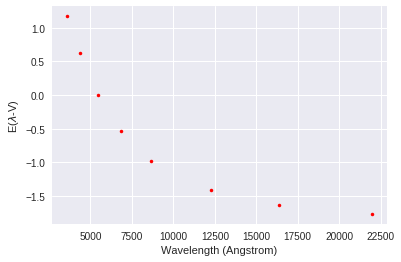

In [27]:
bands = [u_band,b_band,v_band,r_band,i_band,j_band,h_band,k_band]

for band in bands:
  
  # Calculate photometry with dust:
  sp_obs = Observation(sp_ext, band)
  obs_effstim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
  # Calculate photometry without dust
  sp_obs_i = Observation(sp_norm, band)
  obs_i_effstim = sp_obs_i.effstim(flux_unit='vegamag', vegaspec=vega)
  
  plt.plot(sp_obs_i.effective_wavelength(), obs_effstim - obs_i_effstim - Av,'.r')

  plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('E($\lambda$-V)')
plt.show()  

## Exercise
Try changing the blackbody temperature to something very hot or very cool.  Do you get the same thing?  

The extinction changes because the filter transmission is not uniform, so the throughput of the filter depends on the shape of the background source flux.